<a href="https://colab.research.google.com/github/leehanchung/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/module2-convolutional-neural-networks/LS_DS_432_Convolution_Neural_Networks_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

ResNet50 = ResNet50(weights='imagenet')
features = model.predict(x)

```

Next you will need to remove the last layer from the ResNet model. Here, we loop over the layers to use the sequential API. There are easier ways to add and remove layers using the Keras functional API, but doing so introduces other complexities. 

```python
# Remote the Last Layer of ResNEt
ResNet50._layers.pop(0)

# Out New Model
model = Sequential()

# Add Pre-trained layers of Old Model to New Model
for layer in ResNet50.layers:
    model.add(layer)

# Turn off additional training of ResNet Layers for speed of assignment
for layer in model.layers:
    layer.trainable = False

# Add New Output Layer to Model
model.add(Dense(1, activation='sigmoid'))
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/mountain/*`) and images of forests (`./data/forest/*`). Treat mountains as the postive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pretrained layers from resnet
4. Report your model's accuracy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

import zipfile
import pathlib
import random
import os
import matplotlib.pyplot as plt
import cv2 as cv


np.random.seed(45)

AUTOTUNE = tf.data.experimental.AUTOTUNE

TensorFlow 2.x selected.


## Data Preprocessing

In [0]:
# Get the zip files from Google Drive and unzip them into data directory
zip_ref = zipfile.ZipFile("drive/My Drive/mountain.zip", 'r')
zip_ref.extractall("data")
zip_ref = zipfile.ZipFile("drive/My Drive/forest.zip", 'r')
zip_ref.extractall("data")
zip_ref.close()

data_root = pathlib.Path('data')

In [0]:
# Generate list of image paths. There's a .db file in the image directory
# so only glob all the .jpgs
all_image_paths = list(data_root.glob('*/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

In [5]:
data = []
labels = []

for path in all_image_paths:
    # NOT using kera's image libraries, sticking with known devil open cv
    #  img = image.load_img(path, target_size=(224, 224))
    #  x = image.img_to_array(img)
    #  x = np.expand_dims(x, axis=0)
    #  x = preprocess_input(x)
    img = cv.imread(path)
    img = cv.resize(img, (224, 224)) 
    img = img_to_array(img)
    data.append(img)
    
    
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

# create list of labels for all the images
labels = [label_to_index[pathlib.Path(path).parent.name] 
          for path in all_image_paths]

# transform data and labels into numpy arrays
data = np.array(data, dtype='float')
labels = np.array(labels)

# since we are determining mountain or forests, we choose to make it categorical
labels_cat = to_categorical(labels)

assert data.shape[0] == image_count
assert labels_cat.shape[0] == image_count

# and finally splitting them into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data,
	                                                labels_cat, 
                                                    test_size=0.05)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((666, 224, 224, 3), (36, 224, 224, 3), (666, 2), (36, 2))

### Dataset visualization

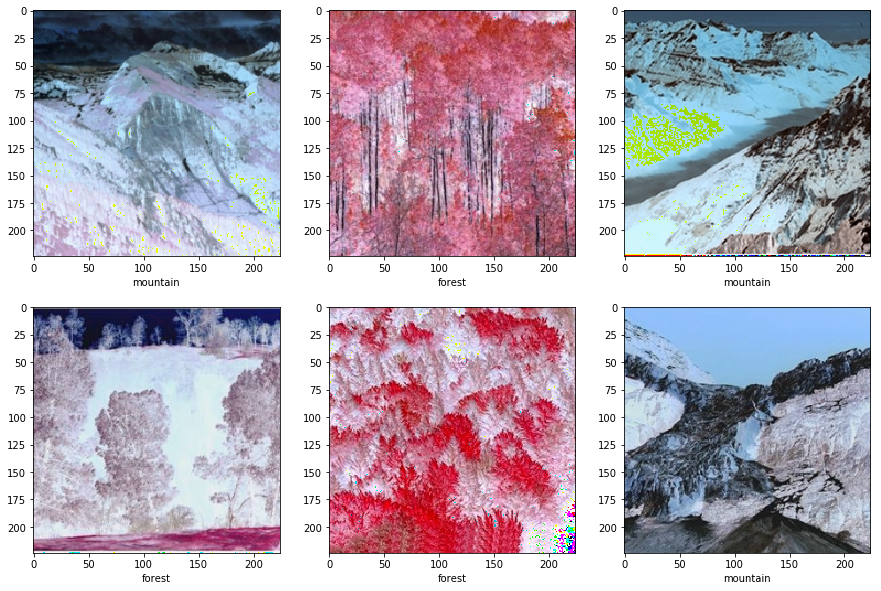

In [6]:
fig = plt.figure(figsize=(15, 10))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow((X_train[i]* 255).astype(np.uint8))
    ax.set_xlabel(label_names[np.argmax(y_train[i])])
plt.show();

## Model

In [0]:
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

plot_model(model)

In [0]:
# could use sparse_categorical_crossentropy for two classes or use
# categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

## Training

In [9]:
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.15, batch_size=BATCH_SIZE, verbose=1)

Train on 566 samples, validate on 100 samples
Epoch 1/5
566/566 [==============================] - 13s 24ms/sample - loss: 0.5696 - accuracy: 0.8604 - val_loss: 0.0800 - val_accuracy: 0.9900
Epoch 2/5
566/566 [==============================] - 5s 9ms/sample - loss: 0.1617 - accuracy: 0.9576 - val_loss: 0.0920 - val_accuracy: 0.9500
Epoch 3/5
566/566 [==============================] - 5s 9ms/sample - loss: 0.0268 - accuracy: 0.9894 - val_loss: 0.0762 - val_accuracy: 0.9600
Epoch 4/5
566/566 [==============================] - 5s 9ms/sample - loss: 0.0129 - accuracy: 0.9982 - val_loss: 0.0751 - val_accuracy: 0.9800
Epoch 5/5
566/566 [==============================] - 5s 9ms/sample - loss: 0.0151 - accuracy: 0.9965 - val_loss: 0.1318 - val_accuracy: 0.9500


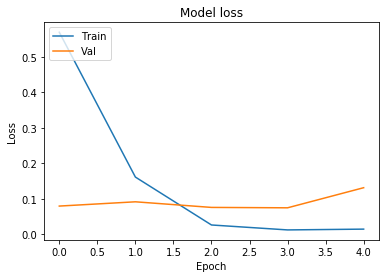

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Validation

In [11]:
# first, validate on test set

score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 1.0


### Visual Validation

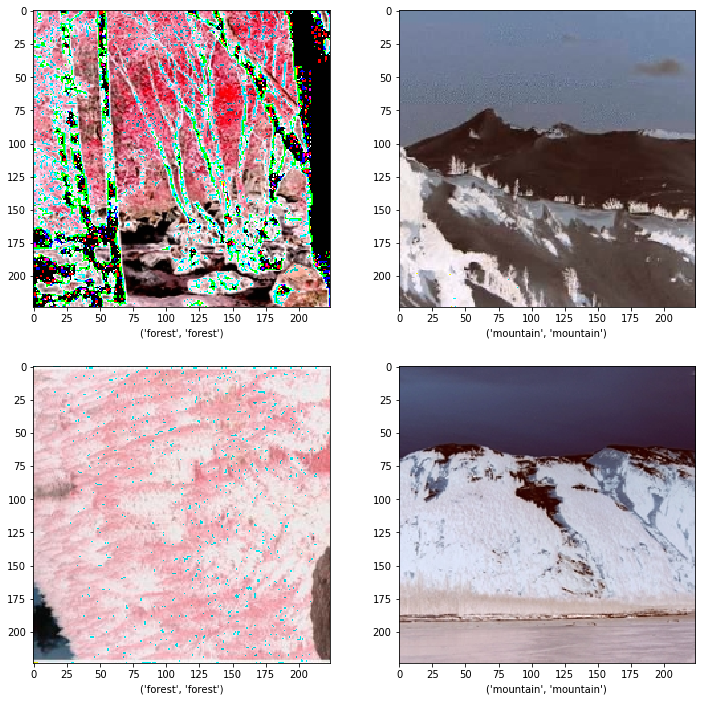

In [12]:
# Predicting the first 4 images of the testing set and plot the images out 
# with both predicted label and ground truth label

pred = model.predict(X_test[0:4])

fig = plt.figure(figsize=(12, 12))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow((X_test[i-1]* 255).astype(np.uint8))
    ax.set_xlabel((label_names[np.argmax(pred[i-1])], 
                   label_names[np.argmax(y_test[i-1])]))
plt.show();

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language